# Vertebral Column Data Classification
>@**Harsha Raidurgam Venkat**

Please install texttable before running this notebook 
```
pip install texttable
```

In [3]:
# Importing Libraries

import copy
import pandas as pd
import numpy as np
import seaborn as sns;
from texttable import Texttable
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
import operator
from scipy.special import expit
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


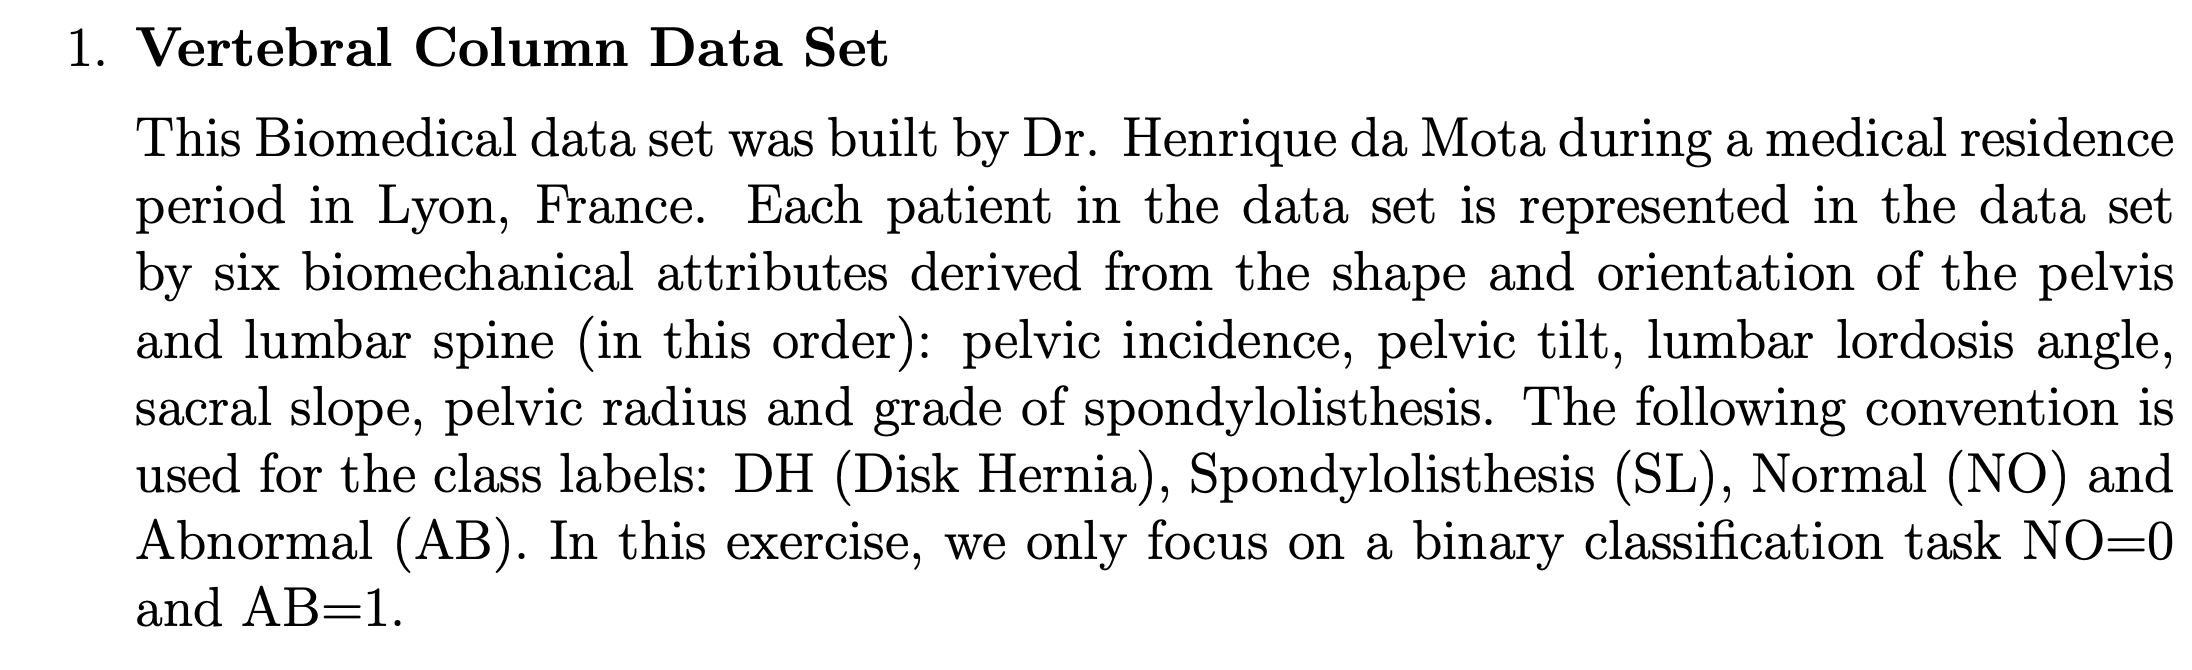

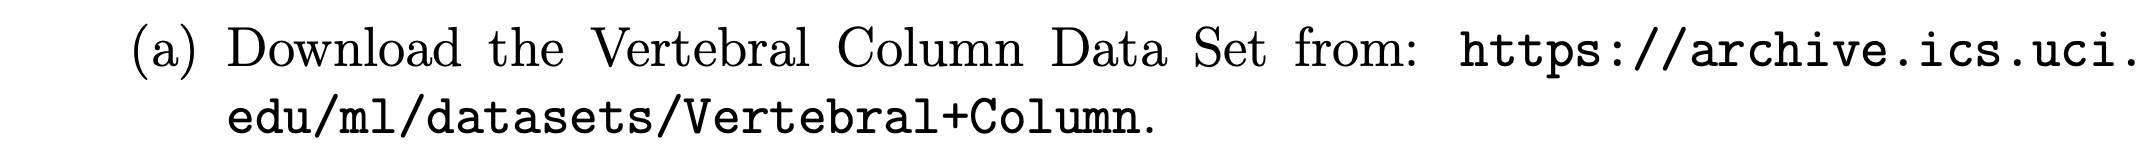

In [ ]:
# Importing the Dataset
df = pd.read_csv('vc_data/column_2C.dat',
                 names=["Pelvic Incidence", 
                        "Pelvic Tilt", 
                        "Lumbar Lordosis Angle", 
                        "Sacral Slop", 
                        "Pelvic Padius", 
                        "Grade Of Spondylolisthesis",
                        "Class"],delim_whitespace=True)

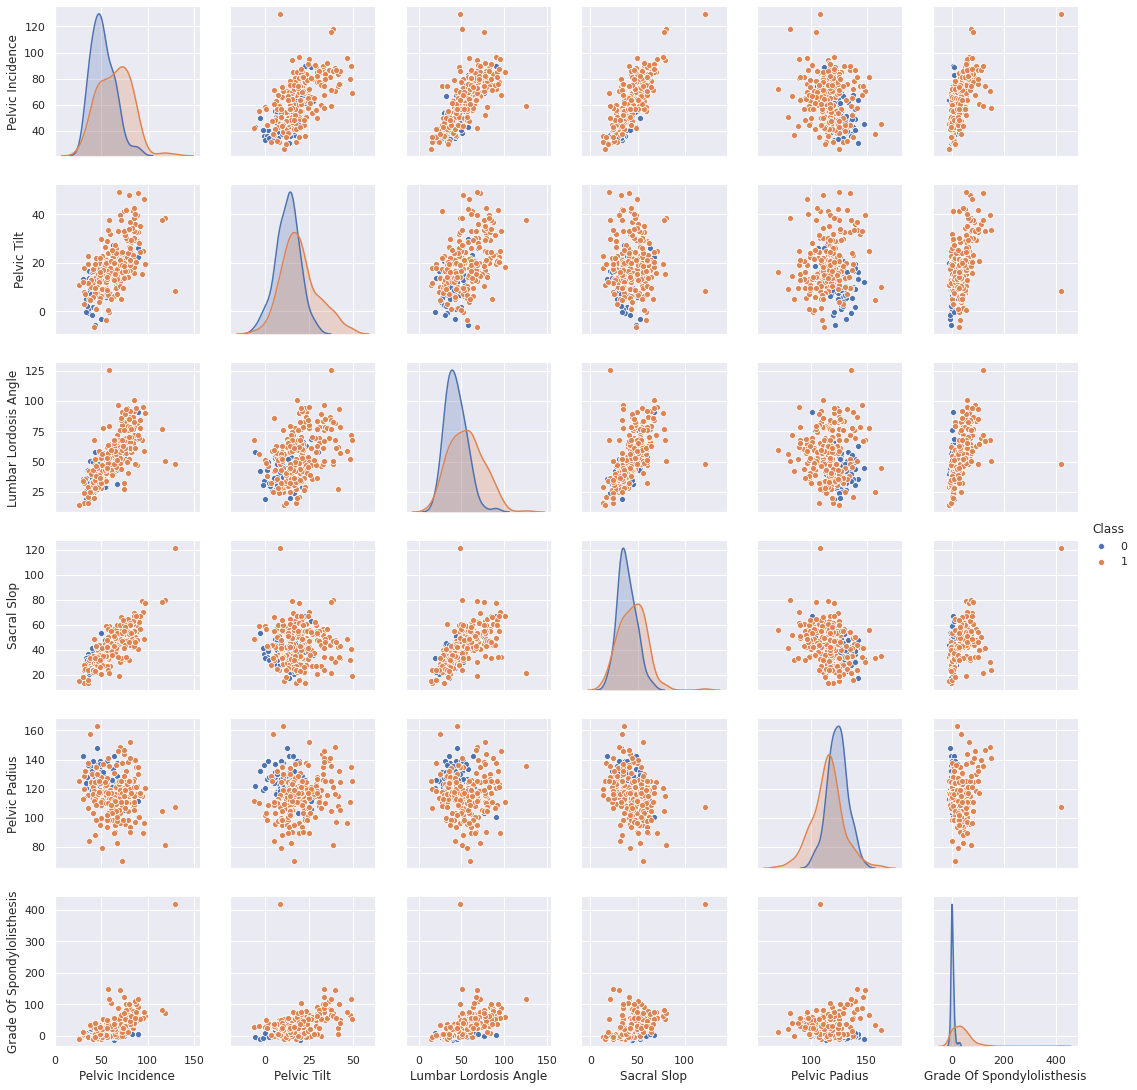

In [5]:
df["Class"].replace({"NO": 0, "AB": 1}, inplace=True)
sns.set(style="darkgrid")
sns.pairplot(df,hue = 'Class')
plt.show()

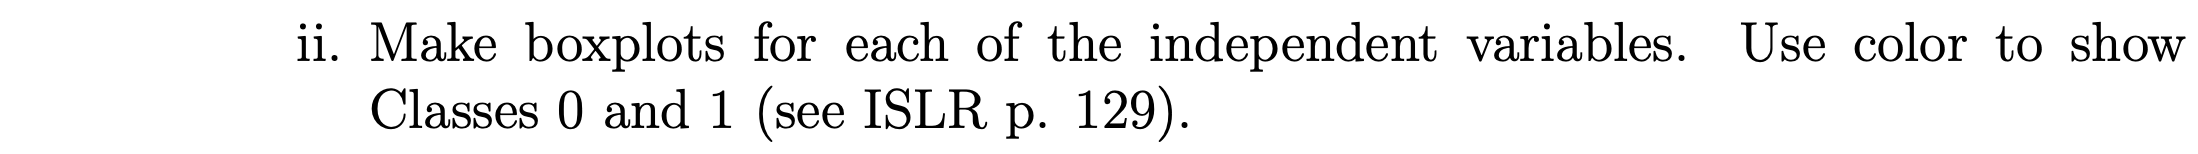

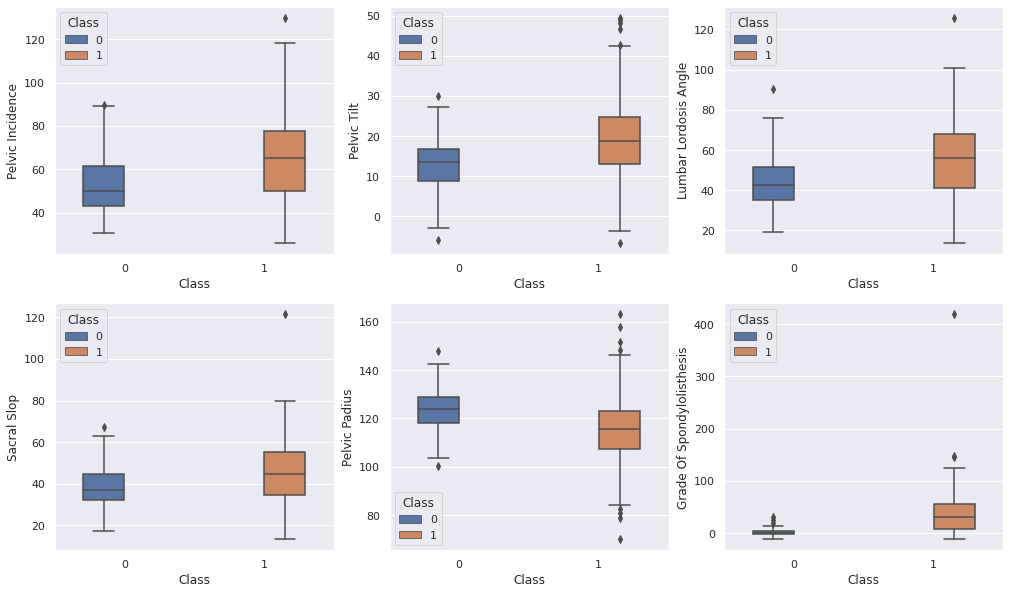

In [6]:
# Below code plots the boxplots in a single plot
# plt.figure(figsize=(13, 7))
# sns.boxplot(x="variable", y="value", data=pd.melt(df,"Class"),hue="Class",width=0.4)
# plt.show()

k = 0
fig, axs = plt.subplots(2,3,figsize=(17,10))
for i in range(0,2):
  for j in range(0,3):
    sns.boxplot(x=df["Class"],y=df.iloc[:,k],data=df,ax=axs[i,j],hue="Class",width=0.6)
    k+=1
plt.show()

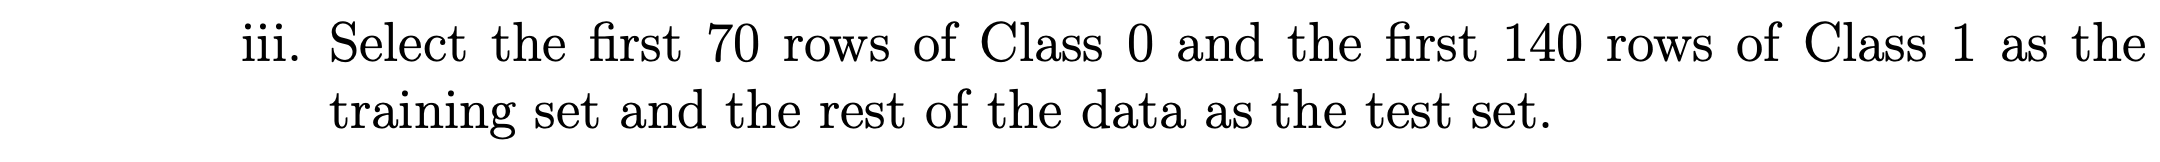

In [ ]:
#Prepare the training and test data
df0 = df.loc[df["Class"]==0]
df1 = df.loc[df["Class"]==1]
train_df = pd.concat([df1.head(140),df0.head(70)])
test_df = pd.concat([df1[140:],df0[70:]])

# Pre-processing
X_train_org = train_df.iloc[:, :-1].values
y_train_org = train_df.iloc[:, 6].values
X_test_org = test_df.iloc[:, :-1].values
y_test_org = test_df.iloc[:, 6].values

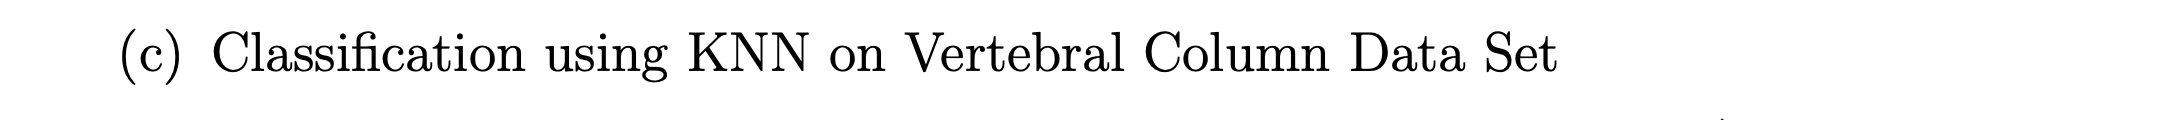

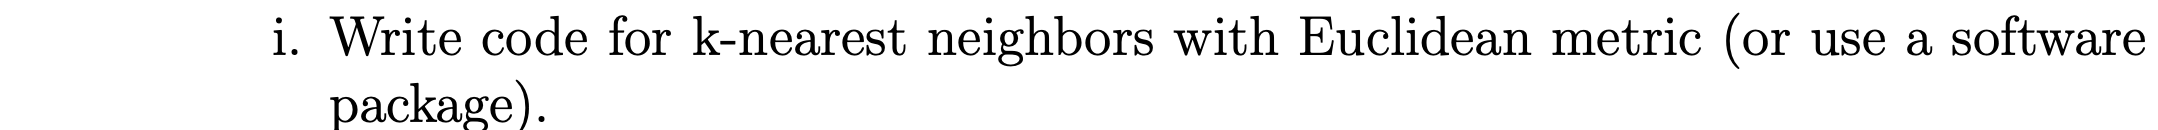

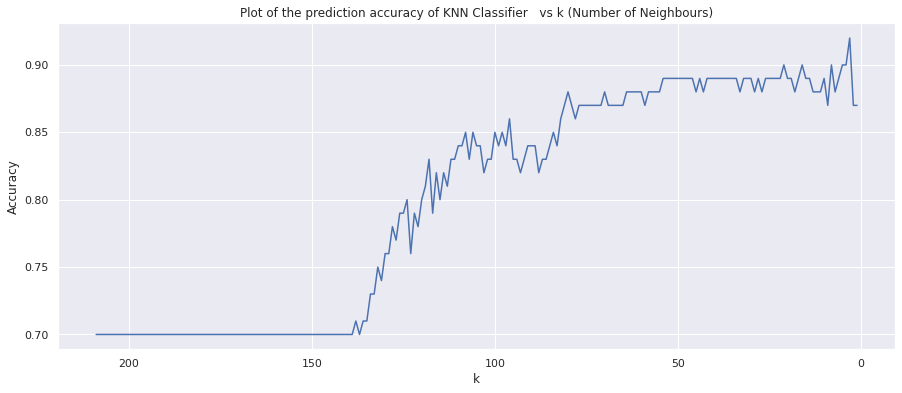

Best K for this Euclidean KNN Classifier is 3


In [8]:
def cal_euc_dist(v1, v2):
    return np.sqrt(np.sum(np.power(v1-v2, 2)))

def get_near_neighbours(X_train, X_test_i, k):
    distances = []
    neighbors = []
    for i in range(0, X_train.shape[0]):
        dist = cal_euc_dist(X_train[i], X_test_i)
        distances.append((i, dist))
    distances.sort(key=operator.itemgetter(1))
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def predictClassVotes(output, y_train):
    votes = {}
    for i in range(len(output)):
        if y_train[output[i]] in votes:
            votes[y_train[output[i]]] += 1
        else:
            votes[y_train[output[i]]] = 1
    sortedVotes = sorted(votes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

def kNN_test(X_train, X_test, Y_train, Y_test, k):
    output_classes = []
    for i in range(0, X_test.shape[0]):
        output = get_near_neighbours(X_train, X_test[i], k)
        prediction = predictClassVotes(output, Y_train)
        output_classes.append(prediction)
    return output_classes

def accuracy(y_pred, original_labels):
    count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == original_labels[i]:
            count += 1
    return float(count)/len(y_pred)
    
def _main_():
  final_classification = {}
  scores = {}

  for k in range(1, 210):
      final_classification[k] = kNN_test(copy.copy(X_train_org), copy.copy(X_test_org), 
                                         copy.copy(y_train_org), copy.copy(y_test_org), k)
      scores[k] = accuracy(final_classification[k], copy.copy(y_test_org))
  
  plt.figure(figsize=(15, 6))
  plt.plot(list(scores.keys()), list(scores.values()))
  plt.xlabel("k")
  plt.ylabel("Accuracy")
  plt.title("Plot of the prediction accuracy of KNN Classifier \
  vs k (Number of Neighbours)")
  ax = plt.gca()
  ax.set_xlim(ax.get_xlim()[::-1])
  plt.show()
  print('Best K for this Euclidean KNN Classifier is',max(scores.items(), 
                                                     key=operator.itemgetter(1))[0])

_main_()

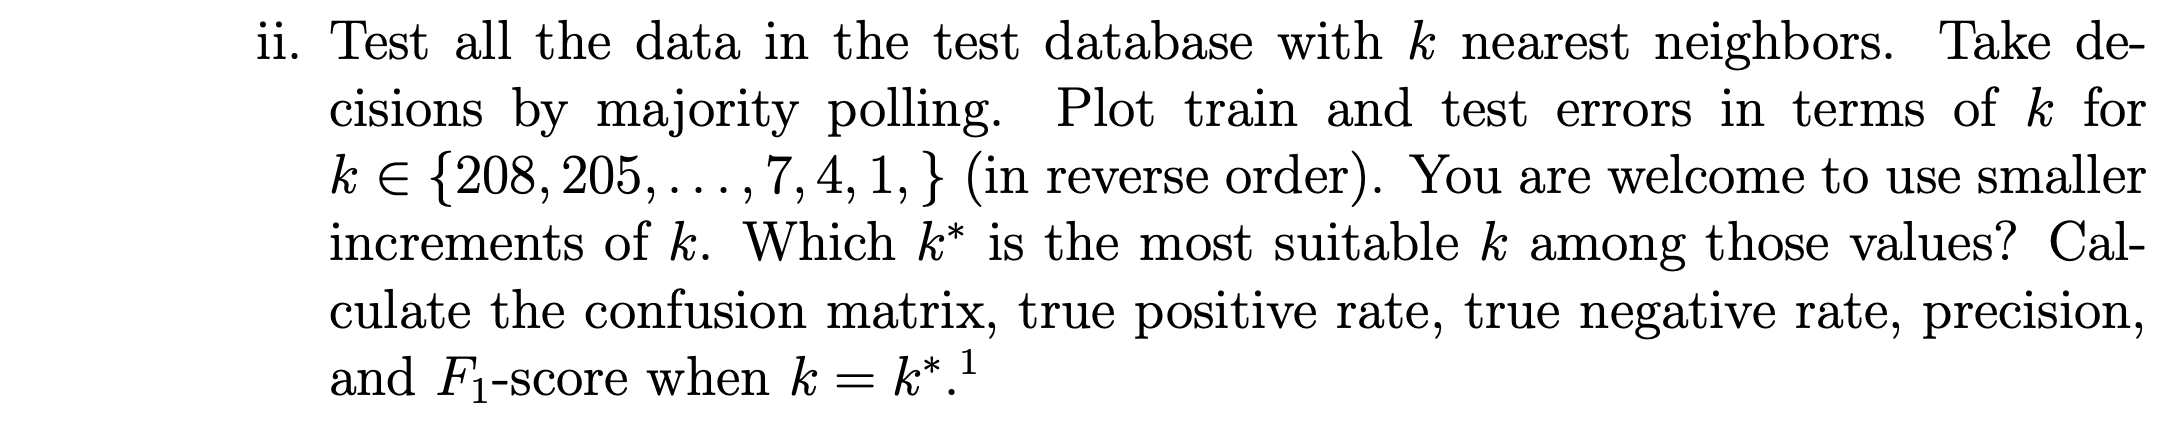

In [ ]:
def knn_classifier(k,metrics):
  
  X_train, y_train, X_test, y_test = copy.copy(X_train_org), copy.copy(y_train_org), copy.copy(X_test_org), copy.copy(y_test_org)
  
  knn = KNeighborsClassifier(algorithm='auto', 
                      leaf_size=30, 
                      metric='minkowski',
                      metric_params=None, 
                      n_jobs=1, 
                      n_neighbors=k, 
                      p=2,
                      weights='uniform')
  
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)
  test_score = accuracy_score(y_test,y_pred)
  test_error = np.mean(y_pred != y_test)
  training_error = np.mean(knn.predict(X_train) != y_train)
  training_score = knn.score(X_train, y_train) 

  if bool(metrics):
    return precision_score(y_test,y_pred), accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), classification_report(y_test,y_pred), confusion_matrix(y_test, y_pred)
  return test_score, test_error , training_score, training_error, y_pred

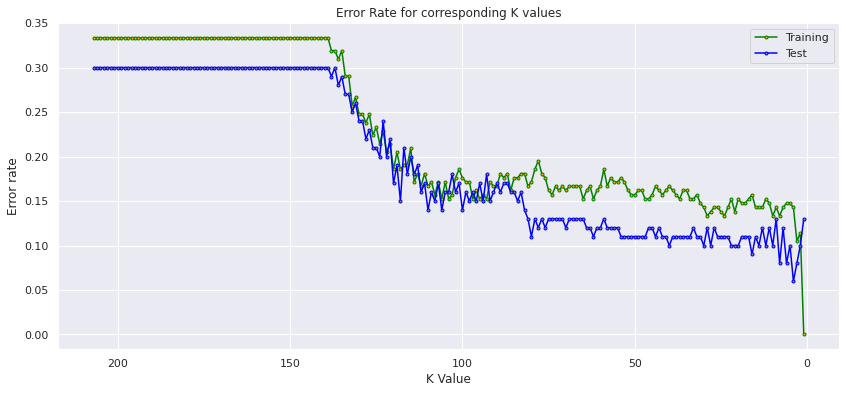

+---------------+---------------+---------------+---------------+--------------+
| Best k* value |  Best Error   |   Precision   |   F1-score    |  Confusion   |
|               |     Rate      |               |               |    Matrix    |
+===============+===============+===============+===============+==============+
| 4             | 0.060         | 0.932         | 0.958         | [[25  5]     |
|               |               |               |               |  [ 1 69]]    |
+---------------+---------------+---------------+---------------+--------------+
| Accuracy      | True Positive | False         | False         | True         |
| Score         | Rate          | Positive Rate | Negative Rate | Negative     |
|               |               |               |               | Rate         |
+---------------+---------------+---------------+---------------+--------------+
| 0.940         | 69            | 5             | 1             | 25           |
+---------------+-----------

In [10]:
def knn_euclidean_test():
  errors = { "training_errors":[],"test_errors":[],"k":[],"y_pred":[]}

  for i in range(1,208,1):
      tup = knn_classifier(i,False)
      errors["training_errors"].append(tup[3])
      errors["test_errors"].append(tup[1])
      errors["k"].append(i)

  plt.figure(figsize=(14, 6))
  plt.plot(errors["k"], errors["training_errors"], color='green', linestyle='solid', marker='o',
          markerfacecolor='orange', markersize=3, label="Training")
  plt.plot(errors["k"], errors["test_errors"], color='blue', linestyle='solid', marker='o',
          markerfacecolor='grey', markersize=3, label="Test")
  plt.title('Error Rate for corresponding K values')
  plt.xlabel('K Value')
  plt.ylabel('Error rate')
  plt.legend(loc="best")
  ax = plt.gca()
  ax.set_xlim(ax.get_xlim()[::-1])
  plt.show()

  min_err = min(errors["test_errors"])
  min_err_indx = errors["test_errors"].index(min_err)
  best_k = errors["k"][min_err_indx]
  test_tup = knn_classifier(best_k,True)

  t = Texttable()
  t.add_rows([['Best k* value', 'Best Error Rate','Precision', 'F1-score',
               'Confusion Matrix'], 
              [best_k, min(errors["test_errors"]), test_tup[0], 
               test_tup[2], np.array(test_tup[4])
              ],['Accuracy Score', 'True Positive Rate', 'False Positive Rate', 
                 'False Negative Rate', 'True Negative Rate'
              ],[test_tup[1], test_tup[4][1][1], test_tup[4][0][1], 
                 test_tup[4][1][0], test_tup[4][0][0]
              ]])
  print(t.draw())
  print("\nKNN Classification Metrics Report\n\n",test_tup[3])

knn_euclidean_test()

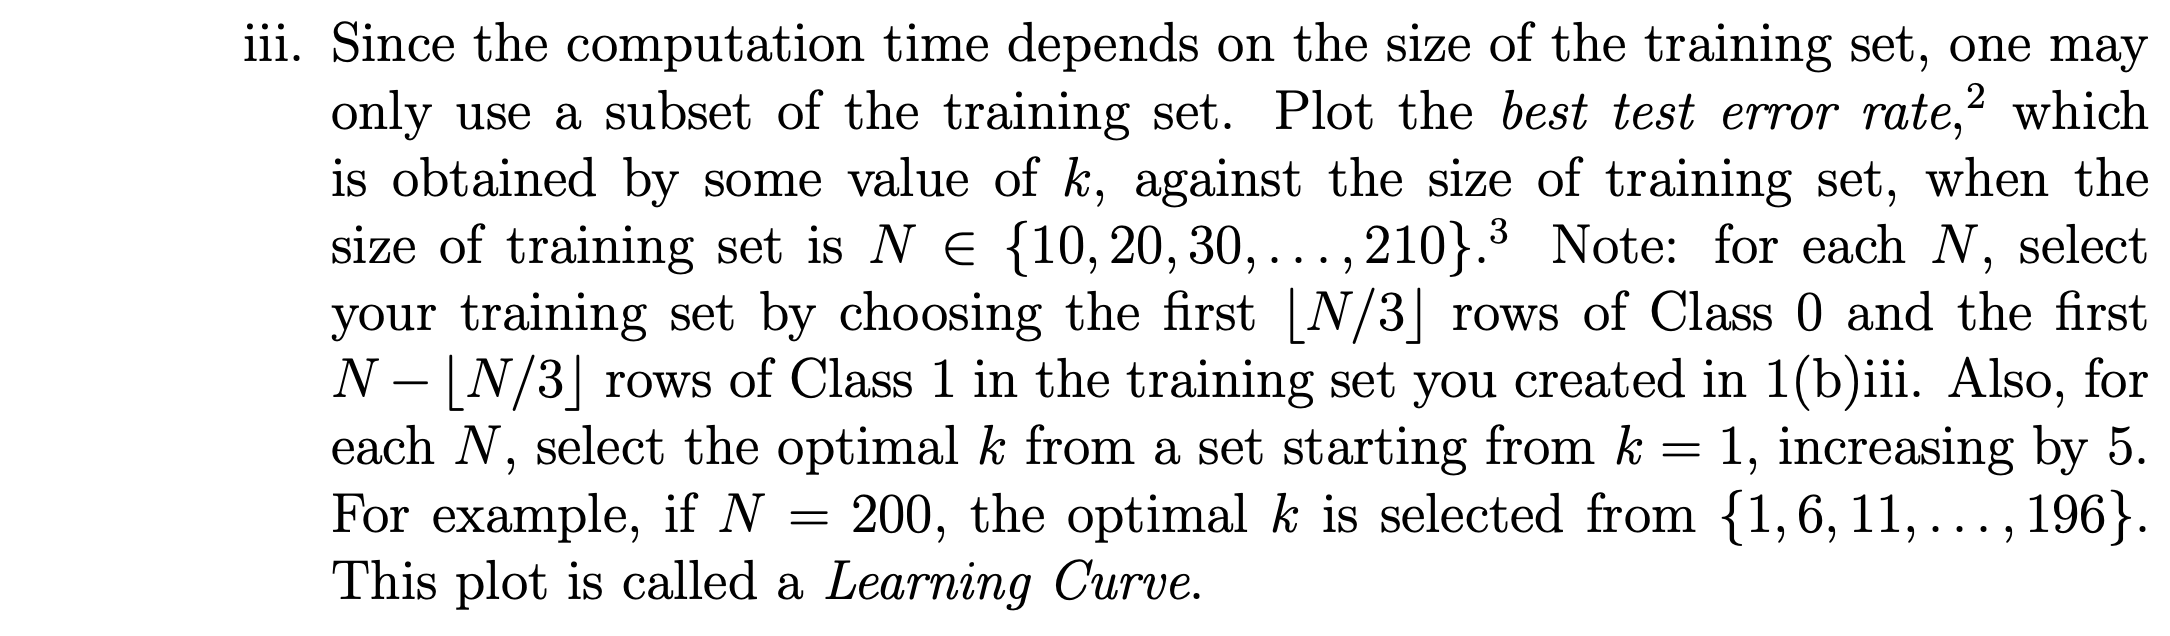

+-----------------------+----------------+----------------+------------+
| Training Set Size (N) | Optimal-K (k*) | Training Error | Test Error |
+=======================+================+================+============+
| 10                    | 1              | 0              | 0.250      |
+-----------------------+----------------+----------------+------------+
| 20                    | 6              | 0.150          | 0.200      |
+-----------------------+----------------+----------------+------------+
| 30                    | 1              | 0              | 0.220      |
+-----------------------+----------------+----------------+------------+
| 40                    | 11             | 0.200          | 0.250      |
+-----------------------+----------------+----------------+------------+
| 50                    | 26             | 0.320          | 0.300      |
+-----------------------+----------------+----------------+------------+
| 60                    | 21             | 0.267   

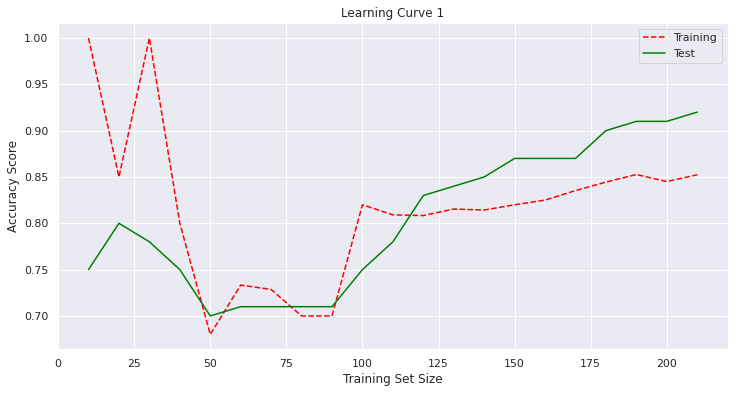

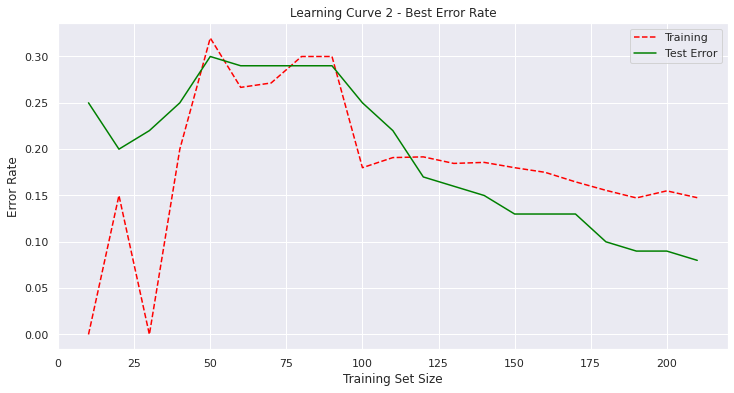

In [11]:
def plot_learning_curve():
  train_metrics = {'K_optimal': [],'N' : [],'Error' : [], 'Accuracy':[]} 
  test_metrics = {'Error' : [], 'Accuracy':[]}
  X_test = copy.copy(X_test_org)
  y_test = copy.copy(y_test_org)

  for n in range(10,211,10):
    train_df = pd.concat([df1.head(int(n-(np.floor(n/3)))),df0.head(int(np.floor(n/3)))])
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, 6].values

    test_score , test_error, training_score, training_error, K = [],[],[],[],[]

    for k in range (1,n,5):
      K.append(k)
      classifier = KNeighborsClassifier(n_neighbors=k)
      classifier.fit(X_train, y_train)
      training_error.append(np.mean(classifier.predict(X_train) != y_train))
      training_score.append(accuracy_score(y_train, classifier.predict(X_train)))
      test_error.append(np.mean(classifier.predict(X_test) != y_test))
      test_score.append(accuracy_score(y_test, classifier.predict(X_test))) 

    test_min_error = min(test_error)
    best_test_err_indx = test_error.index(test_min_error)

    train_metrics["K_optimal"].append(K[best_test_err_indx])
    train_metrics["N"].append(n)
    train_metrics["Error"].append(training_error[best_test_err_indx])
    train_metrics["Accuracy"].append(training_score[best_test_err_indx])

    test_metrics["Error"].append(test_min_error)
    test_metrics["Accuracy"].append(test_score[best_test_err_indx])

  t = Texttable()
  t.header(['Training Set Size (N)', 'Optimal-K (k*)','Training Error', 'Test Error'])

  for row in zip(train_metrics["N"],train_metrics["K_optimal"],train_metrics["Error"],test_metrics["Error"]):
    t.add_row(row)
  print (t.draw())

  plt.figure(figsize=(12, 6))
  plt.plot(train_metrics["N"], train_metrics["Accuracy"], '--', color="red", label="Training")
  plt.plot(train_metrics["N"], test_metrics["Accuracy"] ,'-',color="green", label="Test")
  plt.title("Learning Curve 1")
  plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
  plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(train_metrics["N"], train_metrics["Error"], '--',color="red",  label="Training")
  plt.plot(train_metrics["N"], test_metrics["Error"],color="green",  label="Test Error")
  plt.title("Learning Curve 2 - Best Error Rate")
  plt.xlabel("Training Set Size"), plt.ylabel("Error Rate"), plt.legend(loc="best")
  plt.show()

plot_learning_curve()

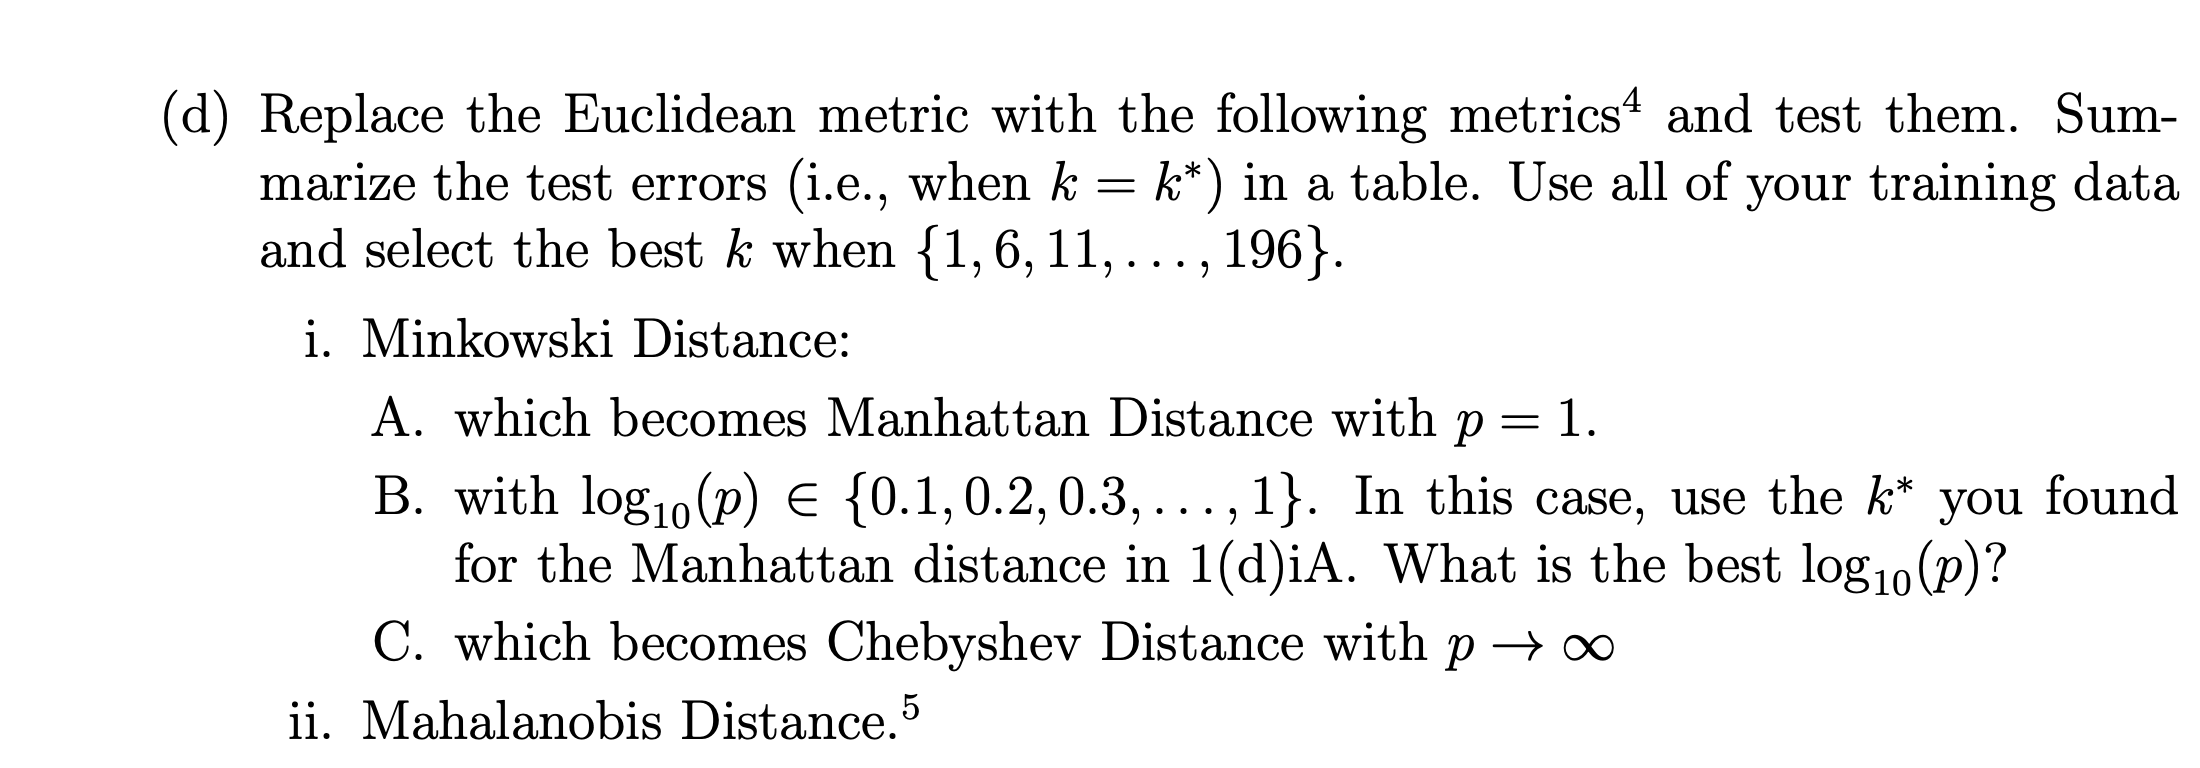

+-----------------+-----------------+--------------+-----------------+---------+
| Distance Metric | Best Test Error | Best K value | Training Error  | Weights |
|                 |      Rate       |              |      Rate       |         |
+=================+=================+==============+=================+=========+
| Manhattan       | 0.110           | 6            | 0.138           | uniform |
+-----------------+-----------------+--------------+-----------------+---------+
| Euclidean       | 0.080           | 6            | 0.148           | uniform |
+-----------------+-----------------+--------------+-----------------+---------+
| Chebyshev       | 0.080           | 16           | 0.148           | uniform |
+-----------------+-----------------+--------------+-----------------+---------+
| Mahalanobis     | 0.160           | 6            | 0.119           | uniform |
+-----------------+-----------------+--------------+-----------------+---------+


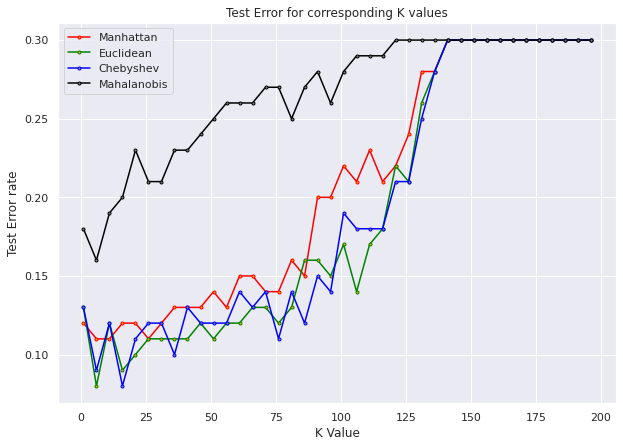

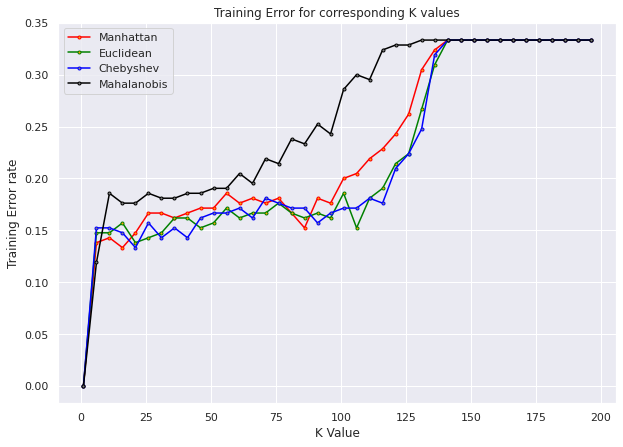

In [12]:
def analyze_metrics(weight):

  man_test_error,euc_test_error,che_test_error,mah_test_error,k = [],[],[],[],[]
  man_train_error,euc_train_error,che_train_error,mah_train_error = [],[],[],[]
  X_train, y_train, X_test, y_test = copy.copy(X_train_org), copy.copy(y_train_org), copy.copy(X_test_org), copy.copy(y_test_org)
  
  for i in range(1,200,5):

      # Create KNN weighted models for different metrics
      manhattan_clf = KNeighborsClassifier(n_neighbors=i,weights=weight,p=1, metric='minkowski')
      euclidean_clf = KNeighborsClassifier(n_neighbors=i,weights=weight,p=2, metric='minkowski')
      chebyshev_clf = KNeighborsClassifier(n_neighbors=i,weights=weight, metric='chebyshev')
      mahalanobis_clf = KNeighborsClassifier(n_neighbors=i,weights=weight ,algorithm='brute',
                                             metric='mahalanobis', 
                                             metric_params={'V': np.cov(X_train)})
      k.append(i)

      man_test_error.append(np.mean(manhattan_clf.fit(X_train, y_train).predict(X_test) != y_test))
      euc_test_error.append(np.mean(euclidean_clf.fit(X_train, y_train).predict(X_test) != y_test))
      che_test_error.append(np.mean(chebyshev_clf.fit(X_train, y_train).predict(X_test) != y_test))
      mah_test_error.append(np.mean(mahalanobis_clf.fit(X_train, y_train).predict(X_test) != y_test))

      man_train_error.append(np.mean(manhattan_clf.fit(X_train, y_train).predict(X_train) != y_train))
      euc_train_error.append(np.mean(euclidean_clf.fit(X_train, y_train).predict(X_train) != y_train))
      che_train_error.append(np.mean(chebyshev_clf.fit(X_train, y_train).predict(X_train) != y_train))
      mah_train_error.append(np.mean(mahalanobis_clf.fit(X_train, y_train).predict(X_train) != y_train))

  t = Texttable()
  t.add_rows([['Distance Metric', 'Best Test Error Rate','Best K value', 'Training Error Rate','Weights'], 
              ['Manhattan', min(man_test_error),k[man_test_error.index(min(man_test_error))],
               man_train_error[man_test_error.index(min(man_test_error))],weight], 
              ['Euclidean', min(euc_test_error),k[euc_test_error.index(min(euc_test_error))],
               euc_train_error[euc_test_error.index(min(euc_test_error))],weight], 
              ['Chebyshev', min(che_test_error),k[che_test_error.index(min(che_test_error))],
               che_train_error[che_test_error.index(min(che_test_error))],weight],
              ['Mahalanobis', min(mah_test_error),k[mah_test_error.index(min(mah_test_error))],
               mah_train_error[mah_test_error.index(min(mah_test_error))],weight]])
  print(t.draw())

  # Test Error Plot
  plt.figure(figsize=(10, 7))
  plt.plot(k, man_test_error, color='red', linestyle='solid', marker='o',
          markerfacecolor='orange', markersize=3, label="Manhattan")
  plt.plot(k, euc_test_error, color='green', linestyle='solid', marker='o',
          markerfacecolor='orange', markersize=3, label="Euclidean")
  plt.plot(k, che_test_error, color='blue', linestyle='solid', marker='o',
          markerfacecolor='grey', markersize=3, label="Chebyshev")
  plt.plot(k, mah_test_error, color='black', linestyle='solid', marker='o',
          markerfacecolor='grey', markersize=3, label="Mahalanobis")
  plt.title('Test Error for corresponding K values')
  plt.xlabel('K Value')
  plt.ylabel('Test Error rate')
  plt.legend(loc="best")
  plt.show()

  # Trining Error plot
  plt.figure(figsize=(10, 7))
  plt.plot(k, man_train_error, color='red', marker='o',
           markerfacecolor='orange', markersize=3, label="Manhattan")
  plt.plot(k, euc_train_error, color='green', marker='o',
           markerfacecolor='orange', markersize=3, label="Euclidean")
  plt.plot(k, che_train_error, color='blue', marker='o',
           markerfacecolor='grey', markersize=3, label="Chebyshev")
  plt.plot(k, mah_train_error, color='black', marker='o',
           markerfacecolor='grey', markersize=3, label="Mahalanobis")

  plt.title('Training Error for corresponding K values')
  plt.xlabel('K Value')
  plt.ylabel('Training Error rate')
  plt.legend(loc="best")
  plt.show()

analyze_metrics('uniform')

**Code for 1.(d).i.B is written below**

+-------------+-------------+-------------+-------------+------------+---------+
|  Distance   |  Best Test  |  Training   |   Best P    |    Best    | Weights |
|   Metric    | Error Rate  | Error Rate  |    value    |   log(p)   |         |
+=============+=============+=============+=============+============+=========+
| Manhattan   | 0.060       | 0.152       | 3.981       | 0.600      | uniform |
+-------------+-------------+-------------+-------------+------------+---------+


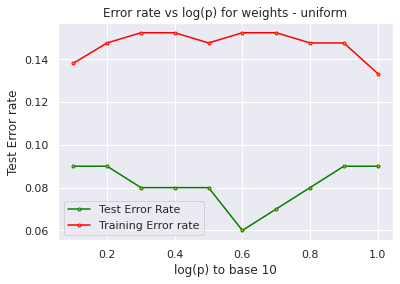

+-------------+-------------+-------------+------------+------------+----------+
|  Distance   |  Best Test  |  Training   |   Best P   |    Best    | Weights  |
|   Metric    | Error Rate  | Error Rate  |   value    |   log(p)   |          |
+=============+=============+=============+============+============+==========+
| Manhattan   | 0.100       | 0           | 1.995      | 0.300      | distance |
+-------------+-------------+-------------+------------+------------+----------+


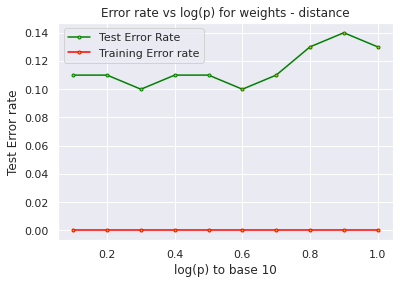

In [13]:
def best_log_p(weight):

  k, p_vals, man_train_error, man_test_error = [], [], [], []
  X_train, y_train, X_test, y_test = copy.copy(X_train_org), copy.copy(y_train_org), copy.copy(X_test_org), copy.copy(y_test_org)
  log_p = 0.1

  while log_p <= 1:

      p_val = pow(10,log_p)

      # K=6 is the best K for Manhattan distance metric determined in 1.(d),i.A
      manhattan_clf = KNeighborsClassifier(n_neighbors=6, weights=weight,p=p_val, metric='minkowski')
      k.append(log_p)
      p_vals.append(p_val)
      log_p+=0.1
      man_test_error.append(np.mean(manhattan_clf.fit(X_train, y_train).predict(X_test) != y_test))
      man_train_error.append(np.mean(manhattan_clf.fit(X_train, y_train).predict(X_train) != y_train))
  
  low_err_inx = man_test_error.index(min(man_test_error))

  t = Texttable()
  t.add_rows([['Distance Metric', 'Best Test Error Rate','Training Error Rate','Best P value', 
               'Best log(p)', 'Weights'], 
              ['Manhattan', min(man_test_error),man_train_error[low_err_inx], p_vals[low_err_inx]
               , k[low_err_inx], weight]])
  print(t.draw())

  plt.plot(k, man_test_error, color='green', linestyle='solid', marker='o',
          markerfacecolor='orange', markersize=3, label="Test Error Rate")
  plt.plot(k, man_train_error, color='red', linestyle='solid', marker='o',
          markerfacecolor='orange', markersize=3, label="Training Error rate")
  plt.title('Error rate vs log(p) for weights - '+weight)
  plt.xlabel('log(p) to base 10')
  plt.ylabel('Test Error rate')
  plt.legend(loc="best")

  plt.show()

best_log_p('uniform')
best_log_p('distance')

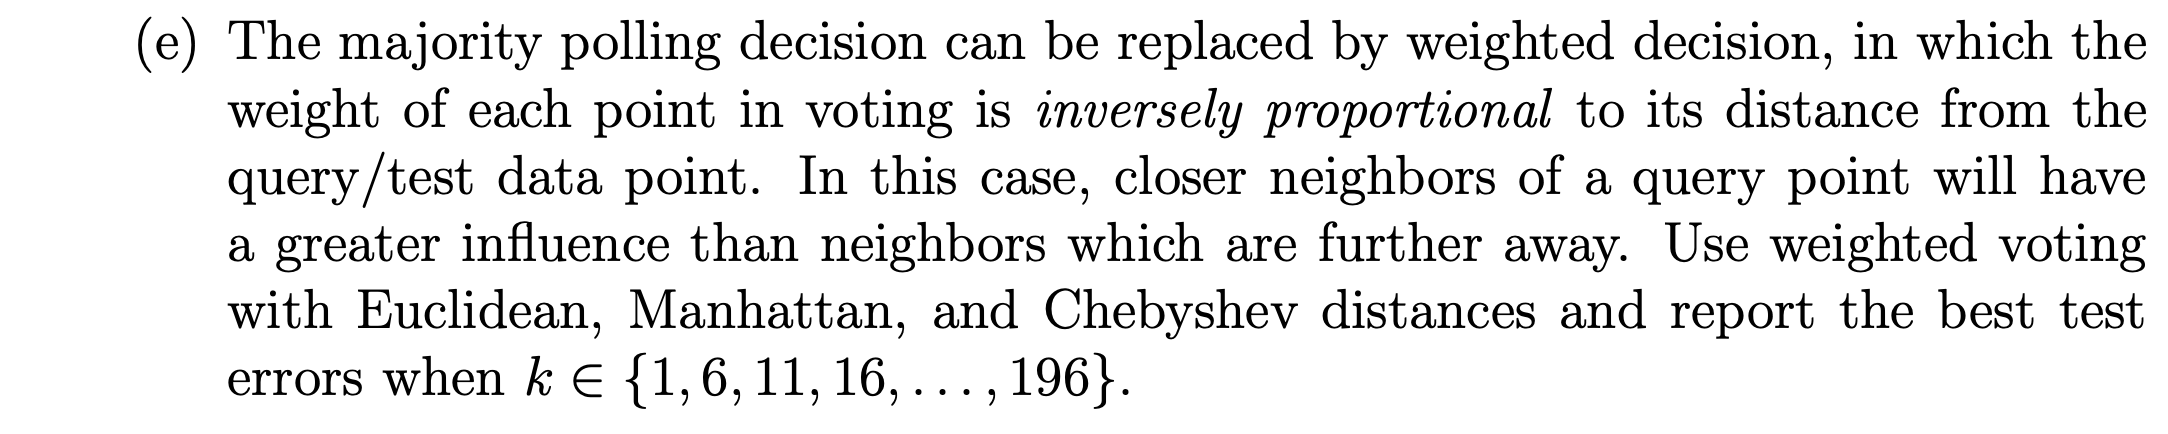

+-----------------+-----------------+--------------+----------------+----------+
| Distance Metric | Best Test Error | Best K value | Training Error | Weights  |
|                 |      Rate       |              |      Rate      |          |
+=================+=================+==============+================+==========+
| Manhattan       | 0.100           | 26           | 0              | distance |
+-----------------+-----------------+--------------+----------------+----------+
| Euclidean       | 0.100           | 6            | 0              | distance |
+-----------------+-----------------+--------------+----------------+----------+
| Chebyshev       | 0.110           | 16           | 0              | distance |
+-----------------+-----------------+--------------+----------------+----------+
| Mahalanobis     | 0.170           | 11           | 0              | distance |
+-----------------+-----------------+--------------+----------------+----------+


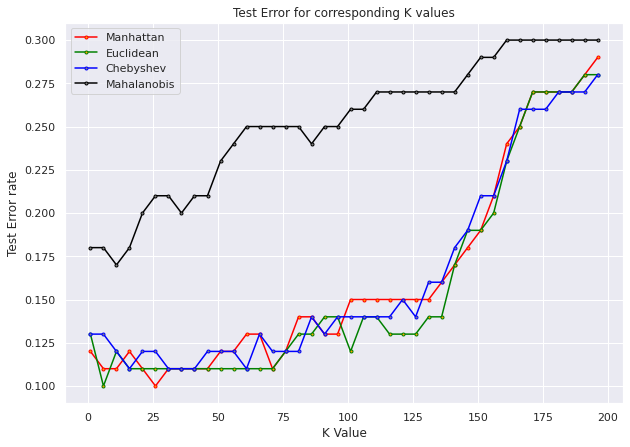

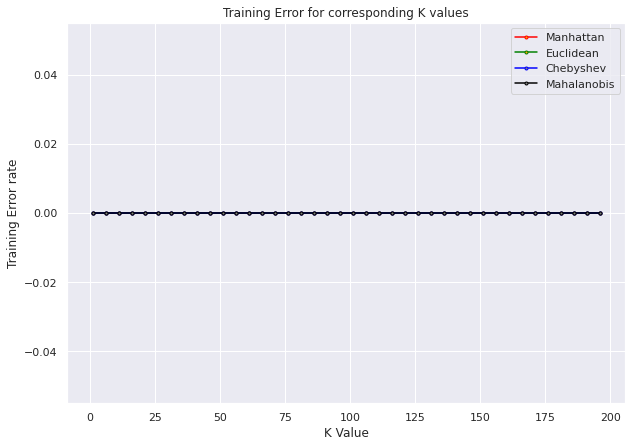

In [14]:
analyze_metrics('distance')

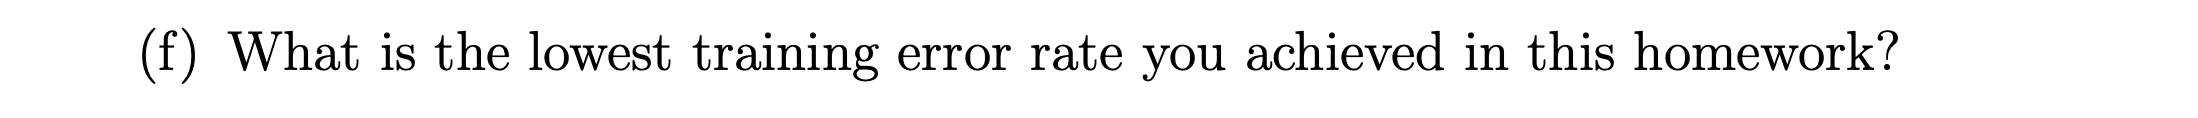

**Lowest Training Error Rate**: 0.00

---
**Lowest Test Error Rate** : 0.06
